# Spam SMS Classification

In this notebook, we will be developing a classifier that detects when a message is a spam message based on text input.

## Load Data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

In [47]:
# Load in the data
df = pd.read_csv('./data/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We have some unnamed columns with Not a Number (NaN) values so we're just drop these columns since it will be irrelavant to the project

In [48]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

To make this easier, let's rename the columns v1 and v2 into something more semantic X_X

In [49]:
# Rename columns so that they are more clear
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)

In [50]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Exploration

As we normally do, we check if our data has missing values and deal with them as necessary via imputation methods.

In [51]:
# check for missing values
df.isnull().sum()

label    0
text     0
dtype: int64

Good, there are no missing values!

In cases like spam classification, it's typical for us to face imbalanced dataset since of the thousands of sms messages, you'll only have a few scam messages. But let's visualize how many of these messages in our dataset are scam  messages and how many aren't.

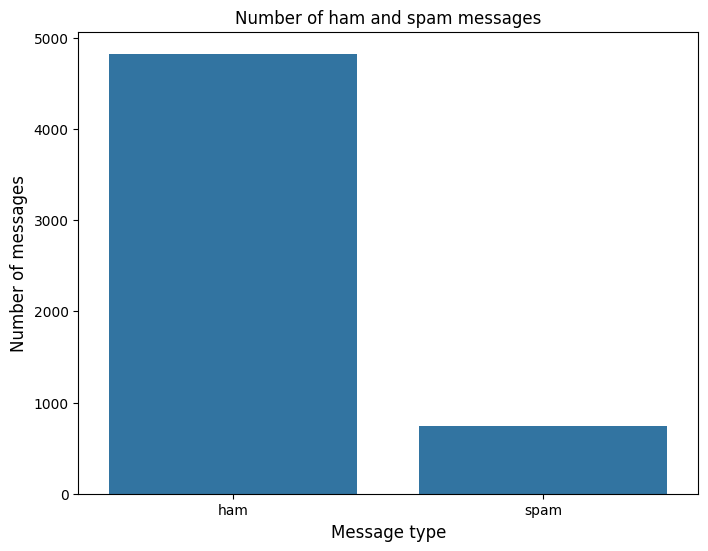

In [52]:
# count the number of spam and ham instances
ham_spam = df.label.value_counts()

# Visualize the count
plt.figure(figsize=(8, 6))
sns.barplot(x=ham_spam.index, y=ham_spam.values)
plt.title('Number of ham and spam messages')
plt.ylabel('Number of messages', fontsize=12)
plt.xlabel('Message type', fontsize=12)
plt.show()

It's just as we thought, there are little ham (non-spam) messages than spam messages. Let's also count the number of sentences, words and characters for each row to explore the data more.

ALSO, note that I applied tokenization to break paragraphs into individual sentences and words respectively. We'll go into what tokenization is later

In [53]:
import nltk

# add columns sentences, characters, and words
#Adding a column of numbers of charachters,words and sentences in each msg
df["No_of_Characters"] = df["text"].apply(len)
df["No_of_Words"]=df.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)

df.head()


,label,text,No_of_Characters,No_of_Words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


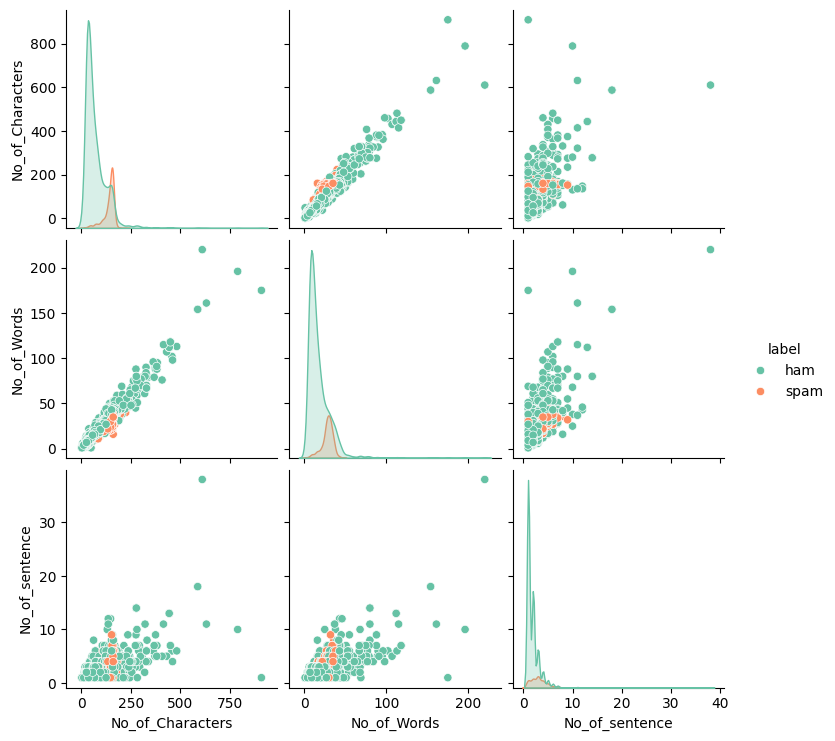

In [55]:
# Make pairplot to detect any correlation between features and outliers
sns.pairplot(df, hue='label', palette='Set2')
plt.show()

From the above pairplot, we can see that there are quite a number of outliers. Let's filter out the data as to remove these outliers.

In [56]:
#Dropping the outliers. 
df = df[(df["No_of_Characters"]<350)]
df.shape

(5548, 5)

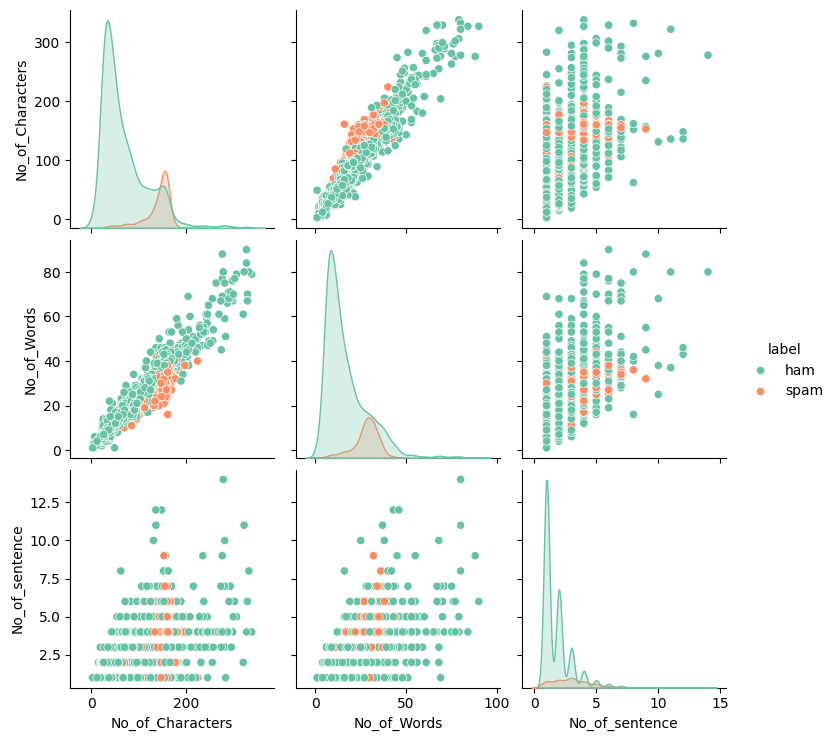

In [57]:
# use pairplot to see change after dropping outliers
sns.pairplot(df, hue='label', palette='Set2')
plt.show()

We'll also look at an example of what a spam and ham message looks like

In [58]:
# look at few examples of ham and spam messages
print('Ham Message')
print(df[df.label == 'ham'].text.iloc[0])
print('\n')
print('Spam Message')
print(df[df.label == 'spam'].text.iloc[0])


Ham Message
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


Spam Message
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


## Data Preprocessing 
Let's now prepare the data for model training. First, we will clean the text data. What this basically means is we will remove all non-alphabetical characters, and replace them with a space. We will then convert all these elements into lowercase to standardize the data and reduce the dimensionality. We split the elements by their spacing (we created the space with regex, now we're removing it). Then we join the words back again

In [60]:
# define a function to clean text
def clean_text(text):
    msg = re.sub('[^a-zA-Z]', ' ', text) # remove non-alphabets
    msg = msg.lower() # convert to lowercase
    msg = msg.split() # split into words
    sms = ' '.join(msg) # join words back
    return sms

# apply the function to clean text
df['cleaned_text'] = df['text'].apply(clean_text)

# look at the cleaned text
print(df['cleaned_text'].iloc[0])


go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


The next step is to tokenize the data. When we tokenize the data, we're breaking down the sentences into a list of words that make up the sentence. These individual words are known as tokens. That's because the vectorisation algorithm we'll be working (TF-IDF) with works on the 'words' level and not on the level of sentences or paragraphs. 

Tokenizing the data also helps if we wanted to visualize word frequency and explore the data further.

In [61]:
# Tokenize the cleaned text
from nltk.tokenize import word_tokenize

df['tokenized_text'] = df['cleaned_text'].apply(word_tokenize)

# print the tokenized text
print(df['tokenized_text'].iloc[0])

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']


Next, we'll remove stop words. These are words that might caryy little meaningful information like 'the', 'for', etc.

In [62]:
# remoe stop words
from nltk.corpus import stopwords

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df['no_stop_words'] = df['tokenized_text'].apply(remove_stopwords)

# print the text without stop words
print(df['no_stop_words'].iloc[0])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']


Finally we will carry out lemmatization. The main idea behind this is to reduce words to it's root form. For example, running would be shortened to run. This helps reduce the dimensionality of your data which in a sense reduces noise in the data.

In [63]:
# lemmatize the text
from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

df['lemmatized_text'] = df['no_stop_words'].apply(lemmatize_text)

# print the lemmatized text
print(df['lemmatized_text'].iloc[0])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']


In [64]:
df.head()

,label,text,No_of_Characters,No_of_Words,No_of_sentence,cleaned_text,tokenized_text,no_stop_words,lemmatized_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, life, around, though]"


now that we've preprocessed our text data, we're going to add the data to our corpus. A corpus is a just a large list of the set of text that we preprocessed.

In [65]:
# Vectorize the text
corpus = []
for i in df['lemmatized_text']:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

# print the corpus
print(corpus[0:5])

['go jurong point crazy available bugis n great world la e buffet cine got amore wat', 'ok lar joking wif u oni', 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply', 'u dun say early hor u c already say', 'nah think go usf life around though']


Finally, we can vectorize the data in the corpus. This is the process of converting our str data to numbers that the machine can understand for training purposes. We're basically converting that corpus to a vector! While we're at it, we'll use the label encoder to set y=0 for non-spam and y=1 for spam messages. 

In [67]:
# Change text to vectors with tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['label'])

# print the shape of X and y
print(X.shape)
print(y.shape)

# print data type of X and y
print(type(X))
print(type(y))



(5548, 6917)
(5548,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Model Training

First we'll split the data into training and testing sets with a 80:20 ratio

In [68]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Then we'll create a list of our desired models to train on the data. Here I'm using a Naive Bayes model, a Support Vector Machine model and a logistic regression model. 

We'll iterate through that list and fit the model with our training data.

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# instantiate the models
models = [MultinomialNB(), SVC(), LogisticRegression()]

# fit the models
for model in models:
    model.fit(X_train, y_train)

## Model Evaluation

Here we use cross validation to evaluate the model. This will help us estimate how the model will generalize to new data.

In [71]:
# evaluate the models with cross val score
from sklearn.model_selection import cross_val_score

for model in models:
    print(f'{model} accuracy: {cross_val_score(model, X_train, y_train, cv=5).mean()}')

MultinomialNB() accuracy: 0.9639484749687682
SVC() accuracy: 0.9731865179723128
LogisticRegression() accuracy: 0.9522314309800217


To help with evaluation, I find that it's helpful to plot a confusion matrix to get an idea of how many correct and incorrect classifications the model made

In [74]:
# plot confusion matrix for each model
from sklearn.metrics import confusion_matrix

collect_cm = {}
for model in models:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    collect_cm[model] = cm

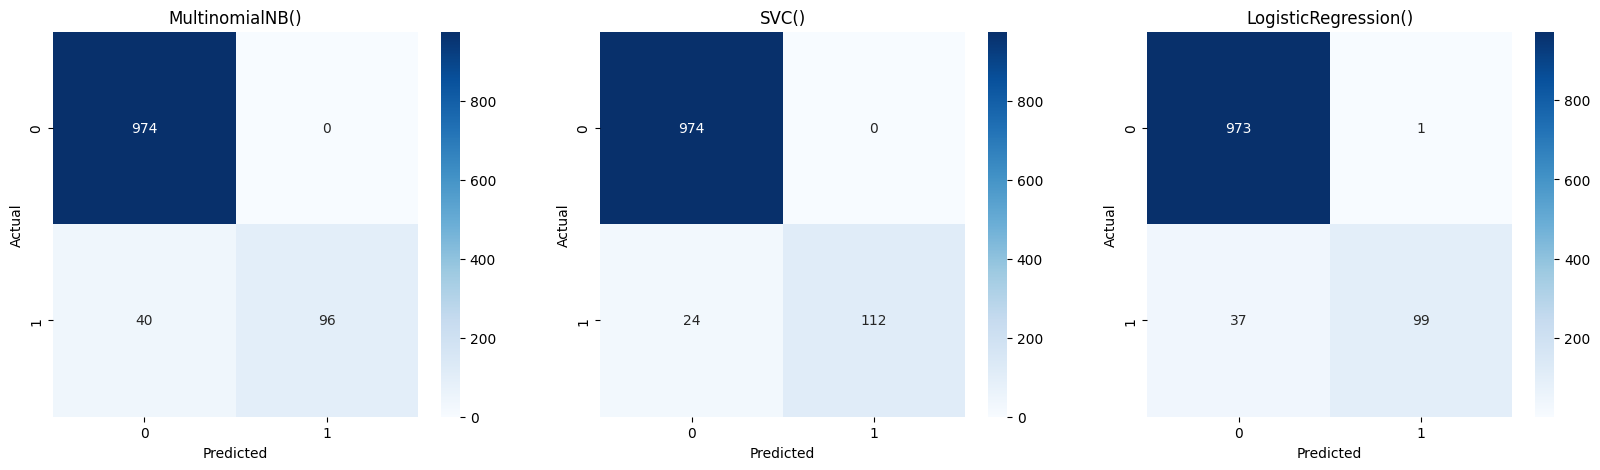

In [78]:
# plot the confusion matrix as seaborn heatmap
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, model in zip(axes, models):
    sns.heatmap(collect_cm[model], annot=True, ax=ax, fmt='d', cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    ax.set_title(model)

As we can see, it looks like the Support Vector Classifier did the best overall in terms of minimizing false classifications.  


## Hyperparameter Tuning

Since we know the support vector classifier is doing well. Let's focus our attention on it and use gridsearch to find the best parameters for the SVC model

In [79]:
# Try to improve the model with GridSearchCV
from sklearn.model_selection import GridSearchCV

# define the parameters
params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# instantiate the model
model = SVC()

# instantiate the gridsearchcv object
grid = GridSearchCV(model, params, cv=5, verbose=3)

# fit the model
grid.fit(X_train, y_train)

# print the best parameters
print(grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.868 total time=  35.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.869 total time=  33.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.867 total time=  32.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.869 total time=  33.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.870 total time=  33.4s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.864 total time=  53.6s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.864 total time=  55.1s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.861 total time=  56.1s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.862 total time=  55.3s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.862 total time=  55.7s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.927 total time=  20.3s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

Now, let's apply those paramers to the model and train the model again and finally we'll evaluate it once more

In [80]:
# apply the best parameters to the model
best_model = SVC(C=100, gamma=0.01, kernel='rbf')

# fit the model
best_model.fit(X_train, y_train)

# evaluate the model
print(f'Accuracy: {best_model.score(X_test, y_test)}')

Accuracy: 0.9846846846846847


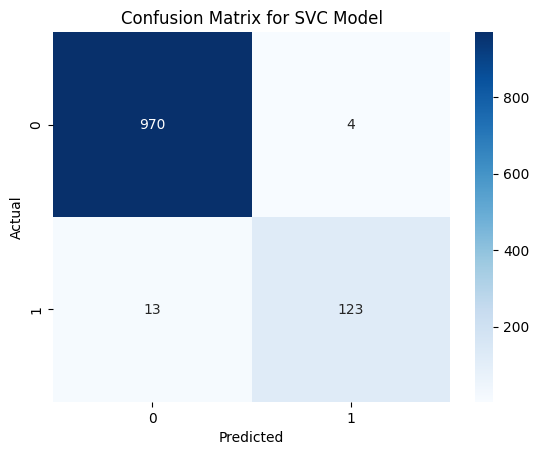

In [81]:
# plot the confusion matrix as seaborn heatmap
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVC Model')
plt.show()


## Conclusion

It looks like after hyperparameter tuning, we were able to increase SVC model accuracy by about 1%. We've also managed to reduce the number of misclassifications from 24 to now 17. Overall we've managed to achieve a model with high accuracy. Moving forward, if we were to improve the model, we can try the following:

1. We can try an ensemble approach 
2. We can try different models, maybe even use deep learning.
3. We can address class imbalance with Synthetic Minority Oversampling Technique to generate new data points for spam cases or even carry out random undersampling. 